## Madaline

In this notebook, we implement Madaline network to separate an artificial data.

### Data

We import proper libraries for future usage:
- numpy: We will use this library for working with arrays.
- pandas: We will use this library to show the structure of the data in dataset.
- seaborn: a Python data visualization library based on matplotlib.
- matplotlib: This library is used for plotting.
- confusion_matrix from sklearn: for visualizing the confusion matrix.
- StandardScaler: We imported this method from sklearn to scale the network's input data.
- make_gaussian_quantiles from sklearn: For creating artificial data.
- train_test_split from sklean: For splitting data to train and test set.

In [2]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split

In the following section we are going to create the artificial data.

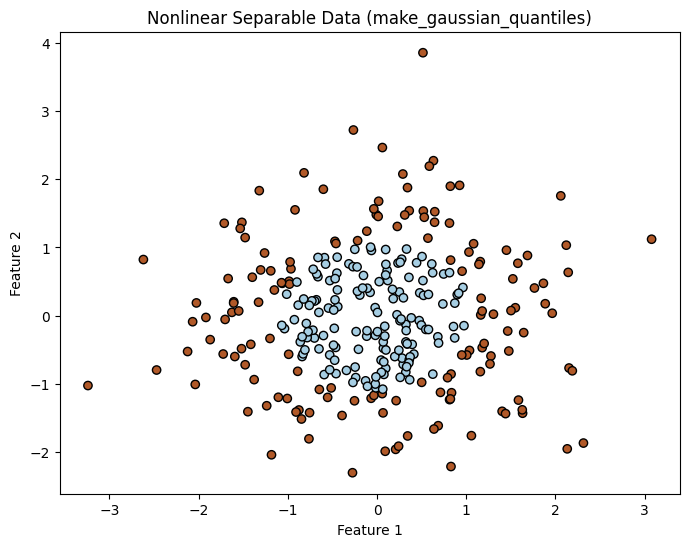

In [3]:
# create data with gaussian distribution
np.random.seed(42)
X, y = make_gaussian_quantiles(n_samples=300, n_features=2,
n_classes=2, random_state=42)
# split data to trai and test (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size=0.2, random_state=42)
# Plot the created data
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, marker='o',
edgecolors='k')
plt.title('Nonlinear Separable Data (make_gaussian_quantiles)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

As in the data targets are 0 or 1, we need to convert them to bipolar for the future usage. Here we change all 0 labels to -1.

In [4]:
y_train = [-1 if el == 0 else 1 for el in y_train]
y_test  = [-1 if el == 0 else 1 for el in y_test]

Now, as we are going to work with random numbers for weights initialization, we have to set a random seed to give same results in different runs.

In [5]:
np.random.seed(313)

### Creating Model

In this section we implemented the Madaline network. As you must know, Madaline is constructed based on Adalines. We have implemented Adaline in the previous section and here we are gonig to implement Madaline based on that. Althogh some of the main parts of the algorithm is similar, but as Adalines are in the hidden layer of the Madaline, there are some small differences.

Madaline has 2 diffrent algoritthms, MRI and MRII. In this project we implementd MRI. This algorithm has some constant weights. In fact, weights of the output layer are all constant and as the output neuron is going to act as a logical OR gate, we have to set these weights baesd on number of neurons in hidden layer. Thus, weights and bias of the output neuron are all set to $\frac{1}{number_of_neurons}$.

Other weights are are initialized with small random numbers to keep them alive.

- **Activation** function: In both hidden and output layer we need activation functions. As in MRI algorithm mentioned, both this activation functions are step function in which they maps all non-negative values to 1 and all negative values to -1.

- **fit**: In fit function in the below class the model will be trained and the loop is going to be continued until the stopping criteria is satisfied. Also, in each epoch the error is computed and we will use this amout to decide if it is needed to update weights.

- **plot_separating_lines** this is a function which plots the seperating lines which are observed in hte fitting process.

- **predict** will bed sued to observe the model's functionality on test set.

- **plot_confusion_matrix**: This function is used to plot the confusion matrxi based on the model predictions and true labels.

- **evaluate**: This function is used to evaluate the model on test set using predict function.

In [6]:
class Madaline:

  def __init__(self, lr, epochs, adalines, random_seed=313):
    # Initialize weights, lr, number of adalines, and epochs.
    self.adalines = adalines
    self.epochs = epochs
    self.learning_rate = lr
    self.bias = 1/self.adalines
    self.weights = [1/self.adalines for _ in range(adalines)]
    self.adalines_weights = [np.random.normal(loc=0, scale=0.01, size=2) for _ in range(self.adalines)]
    self.adalines_biases  = np.random.normal(loc=0, scale=0.01, size=self.adalines)
    np.random.seed(random_seed)

  # Activation function
  def activation(self, input):
    return 1 if input >= 0 else -1

  # Fit the model on train set
  def fit(self, X_train, y_train, min_error):
    loss_hist = []
    epoch = 1

    # While the stopping criteria isn't satisfied, continue
    while epoch <= self.epochs:

      current_errors = []

      # For each input value do the computation and update weights if it is needed.
      for input, target in zip(X_train, y_train):
        z_in = np.zeros(self.adalines)
        z = np.zeros(self.adalines)
        for i in range(self.adalines):
          z_in[i] = np.dot(input, self.adalines_weights[i]) + self.adalines_biases[i]
          z[i]    = self.activation(z_in[i])

        y_in = np.dot(self.weights, z)
        y    = self.activation(y_in)

        error = target - y
        current_errors.append(error)

        # update weights if the error is bot ignorable
        if abs(error) > min_error:
          if target == 1:
            j = np.argmin(np.abs(z_in))
            for i in range(2):
              self.adalines_weights[j][i] += self.learning_rate * input[i] * (target - z_in[j])
            self.adalines_biases[j]  += self.learning_rate * (target - z_in[j])

          else:
            indices = [ind for ind, val in enumerate(z_in) if val >= 0]
            for k in indices:
              self.adalines_biases[k] += self.learning_rate * (target - z_in[k])

              for i in range(2):
                self.adalines_weights[k][i] += self.learning_rate * input[i] * (target - z_in[k])

      mean_error = np.mean(current_errors)
      loss_hist.append(mean_error)
      epoch += 1

    return loss_hist

  # Plot the seperationg lines
  def plot_separating_lines(self, X, y):
        plt.figure(figsize=(8, 6))
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, marker='o', edgecolors='k')

        # Plot separating lines for each Adaline unit
        for i in range(self.adalines):
            w1, w2 = self.adalines_weights[i]
            b = self.adalines_biases[i]
            x_values = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)
            y_values = (-w1 / w2) * x_values - (b / w2)
            plt.plot(x_values, y_values, label=f'Separating Line {i+1}')

        plt.title('Separating Lines of Madaline Network')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.legend()
        plt.xlim((-5, 5))
        plt.ylim((-5, 5))

        plt.show()

  # Predict the labels of X_test and print the accuracy of the model on text set
  def predict(self, X_test, y_test):

    predictions = []
    for input in X_test:
        z_in = np.zeros(self.adalines)
        z = np.zeros(self.adalines)
        for i in range(self.adalines):
            z_in[i] = np.dot(input, self.adalines_weights[i]) + self.adalines_biases[i]
            z[i] = self.activation(z_in[i])
        y_in = np.dot(self.weights, z)
        y = self.activation(y_in)
        predictions.append(y)
    predictions = np.array(predictions)
    accuracy = np.mean(predictions == y_test)
    print("Accuracy on test set:", accuracy)

    self.plot_separating_lines(X_test, y_test)

    return predictions

  # Plot the error history
  def plot_error_history(self, loss_history):
        plt.plot(loss_history)
        plt.title('Error History')
        plt.xlabel('Epoch')
        plt.ylabel('Mean Error')
        plt.grid(True)
        plt.show()

  # Plot confusion matrix
  def plot_confusion_matrix(self, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.show()

  # evaluate the model based on the predictions and true labels.
  def evaluate(self, X_test, y_test):
      test_predictions = self.predict(X_test, y_test)

      # Plot the confusion matrix
      self.plot_confusion_matrix(y_test, test_predictions)

#### Madaline with 3 neurons in hidden layer

In this section we consider 3 number of adalines in the hidden layer. Let's start with:

**learning rate: 0.001, epochs: 200**

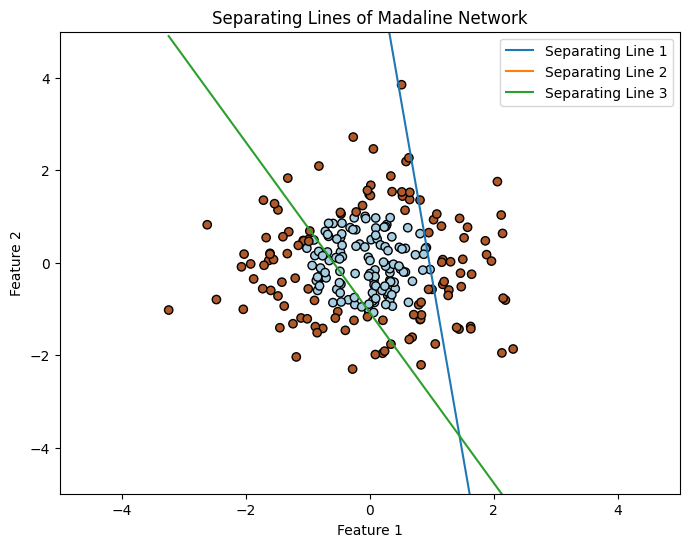

In [7]:
mad3_1  = Madaline(1e-3, 200, 3)
hist3_1 = mad3_1.fit(X_train, y_train, 1e-4)
mad3_1.plot_separating_lines(X_train, y_train)

Evaluate the model on test set

Accuracy on test set: 0.6666666666666666


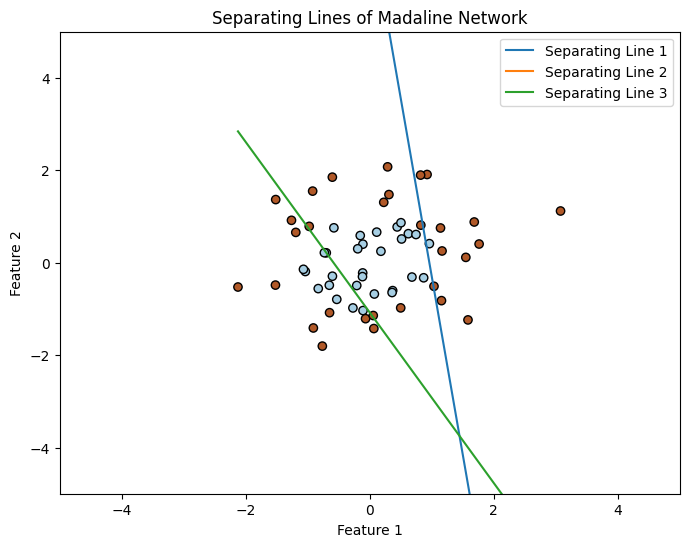

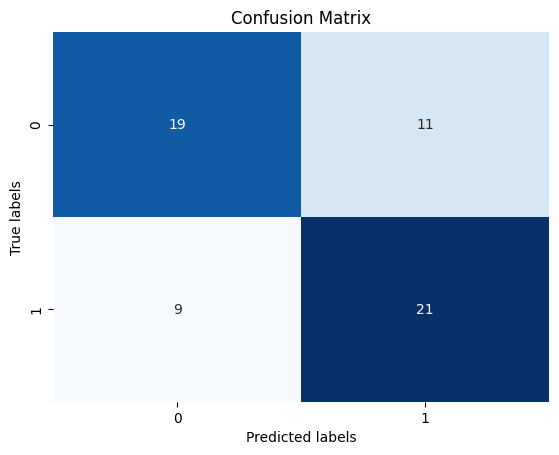

In [8]:
mad3_1.evaluate(X_test, y_test)

As it is shown in the above pictures, the accuracy of the model on test set is aront 67%. As in the plot corresponding to train set we saw, we did not expect a good accuracy because there are only 2 seperationg lines around the data and thi third one in far away.

Now, consider **learning rate: 0.01, epochs: 200**

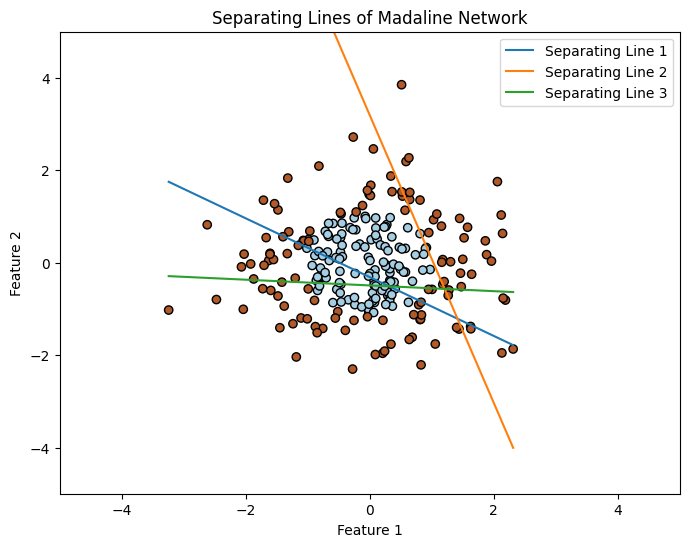

In [9]:
mad3_2  = Madaline(1e-2, 200, 3)
hist3_2 = mad3_2.fit(X_train, y_train, 1e-4)
mad3_2.plot_separating_lines(X_train, y_train)

Accuracy on test set: 0.5666666666666667


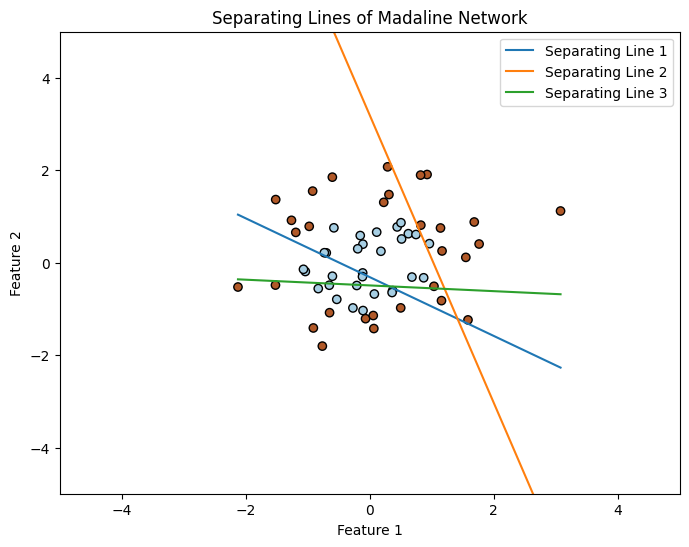

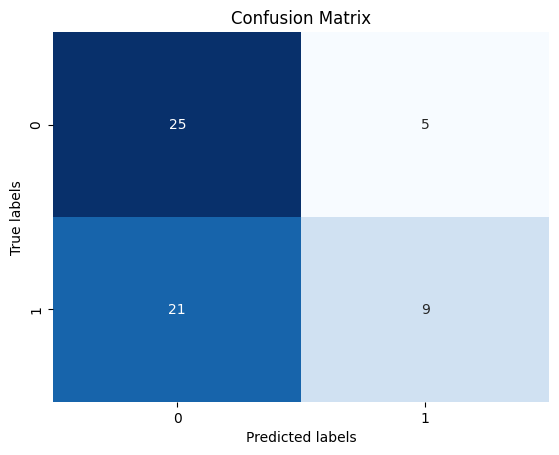

In [10]:
mad3_2.evaluate(X_test, y_test)

Above images show that by increasing learning rate the model acts weaker. Thus, we have to decrease the lr. Now, consider **learning rate: 0.0001, epochs: 200**.

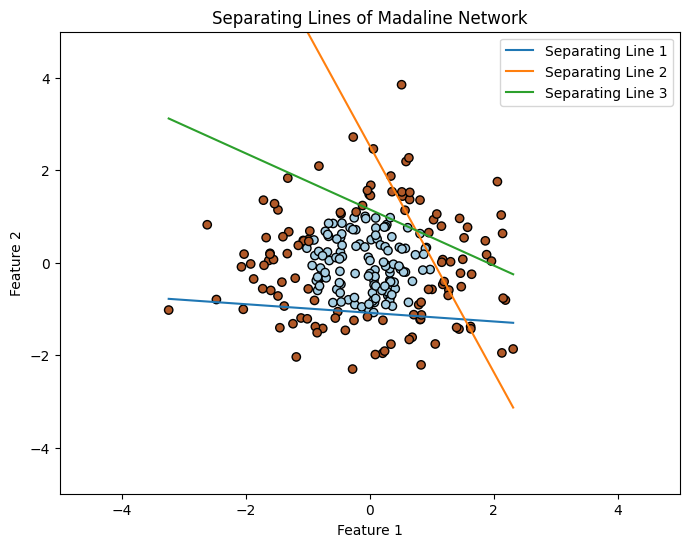

In [11]:
mad3_3  = Madaline(1e-4, 200, 3)
hist3_3 = mad3_3.fit(X_train, y_train, 1e-4)
mad3_3.plot_separating_lines(X_train, y_train)

Accuracy on test set: 0.6333333333333333


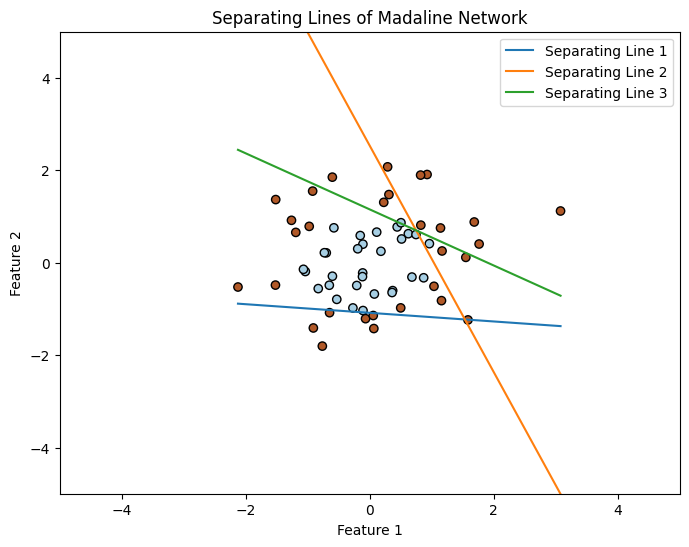

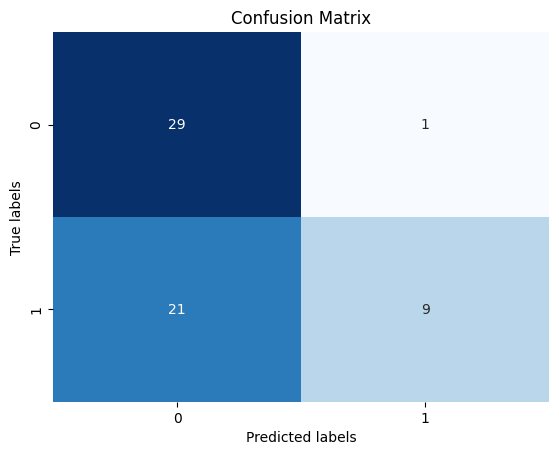

In [12]:
mad3_3.evaluate(X_test, y_test)

Above results show that even by decreasing lr the accuracy of the model on test set decreases. Thus, it's better to consider 0.001 as the learning rate and try to change number of epochs.

**learning rate: 0.001, epochs: 400**

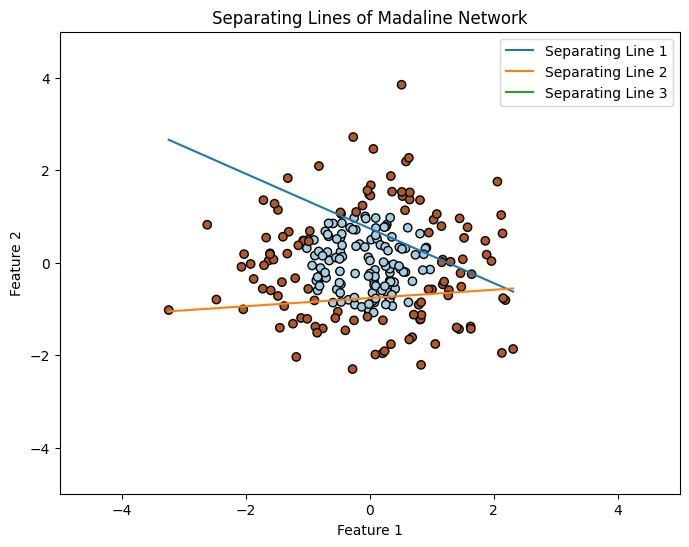

In [13]:
mad3_4  = Madaline(1e-3, 400, 3)
hist3_4 = mad3_4.fit(X_train, y_train, 1e-4)
mad3_4.plot_separating_lines(X_train, y_train)

Accuracy on test set: 0.75


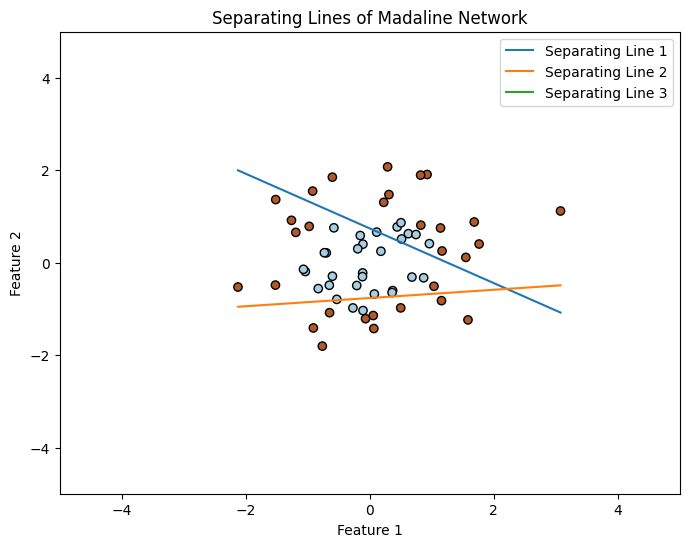

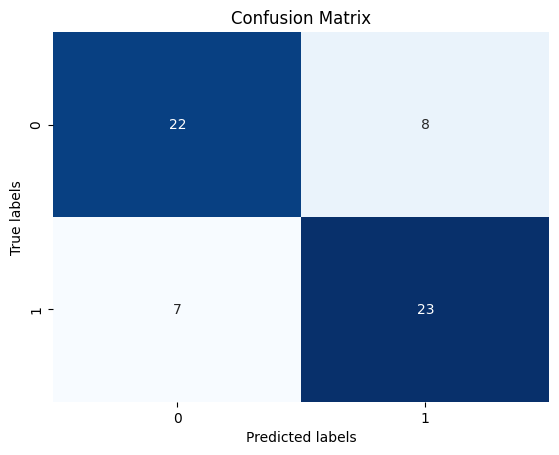

In [14]:
mad3_4.evaluate(X_test, y_test)

With 400 epochs instead of 200 the accuracy increaes to 75%.

**learning rate: 0.001, epochs: 1000**

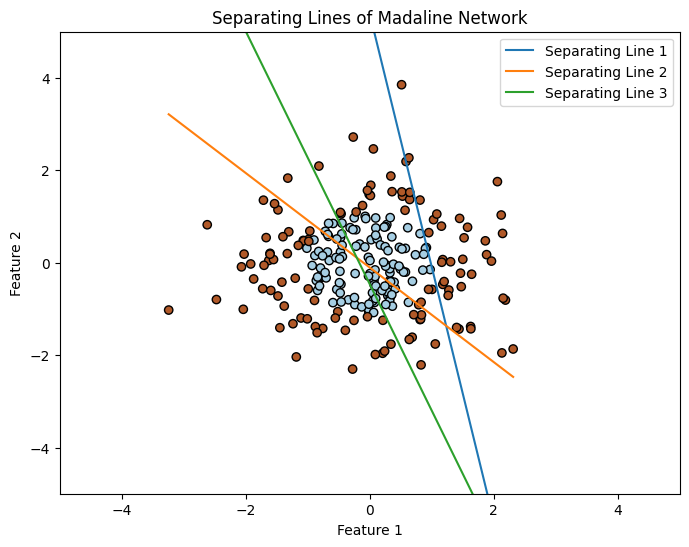

In [ ]:
mad3_5  = Madaline(1e-3, 1000, 3)
hist3_5 = mad3_5.fit(X_train, y_train, 1e-4)
mad3_5.plot_separating_lines(X_train, y_train)

Accuracy on test set: 0.65


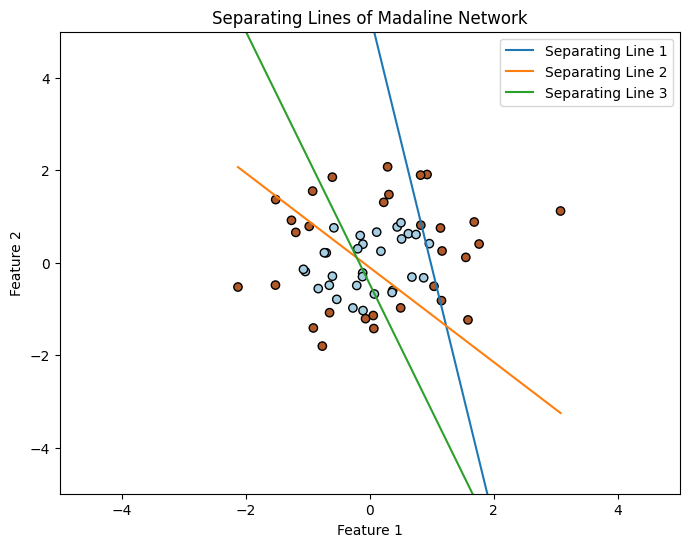

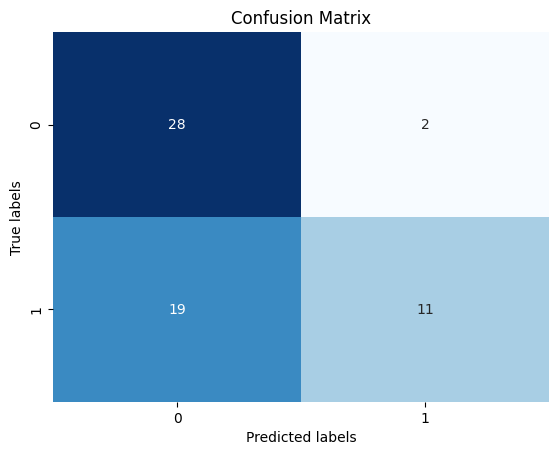

In [45]:
mad3_5.evaluate(X_test, y_test)

With this values of parameters the model's accuracy on test set is 65% which means increasing number of epochs this much, does not change the accuracy a lot. Also, it decreased the accuracy 2%.

**learning rate: 0.001, epochs: 2000**

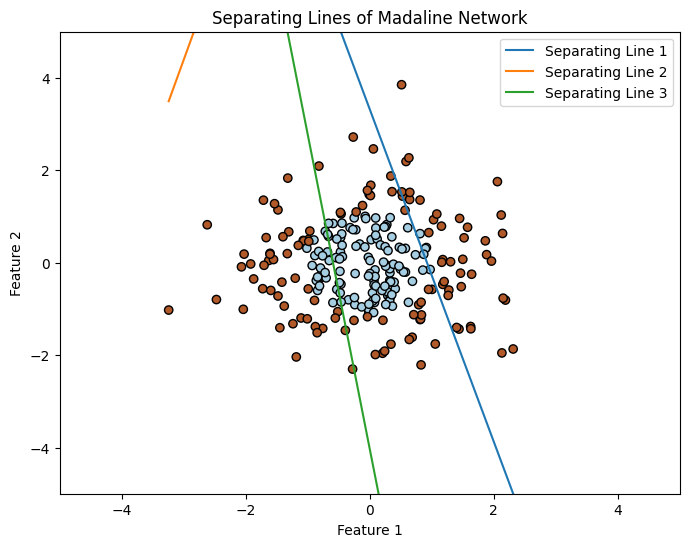

In [46]:
mad3_6  = Madaline(1e-3, 2000, 3)
hist3_6 = mad3_6.fit(X_train, y_train, 1e-4)
mad3_6.plot_separating_lines(X_train, y_train)

Accuracy on test set: 0.7


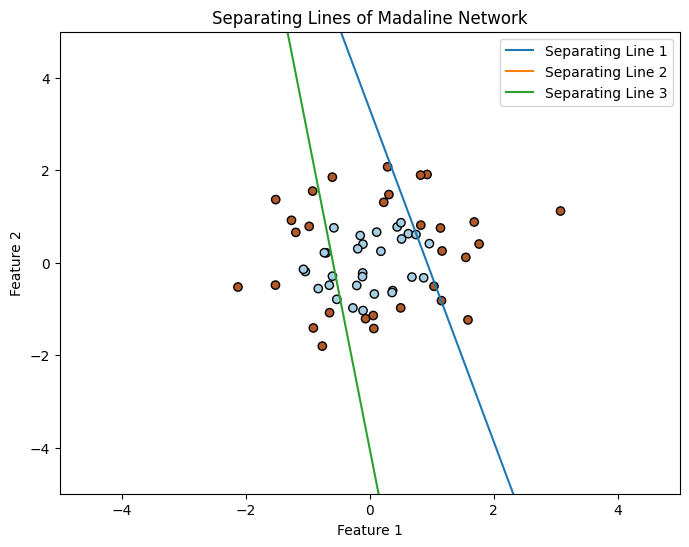

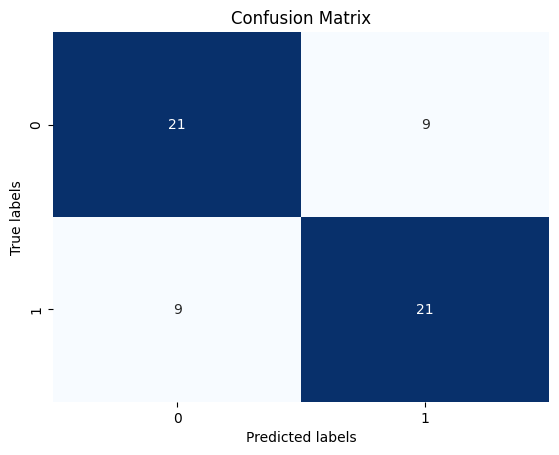

In [47]:
mad3_6.evaluate(X_test, y_test)

Doubling the nuber of epochs causes 70% accuracy on test set with 3 adalines in hiddem layer. So, we wish increasing number of epochs increase the accuracy more and more. Let's try larger numbers.

**learning rate: 0.001, epochs: 3000**

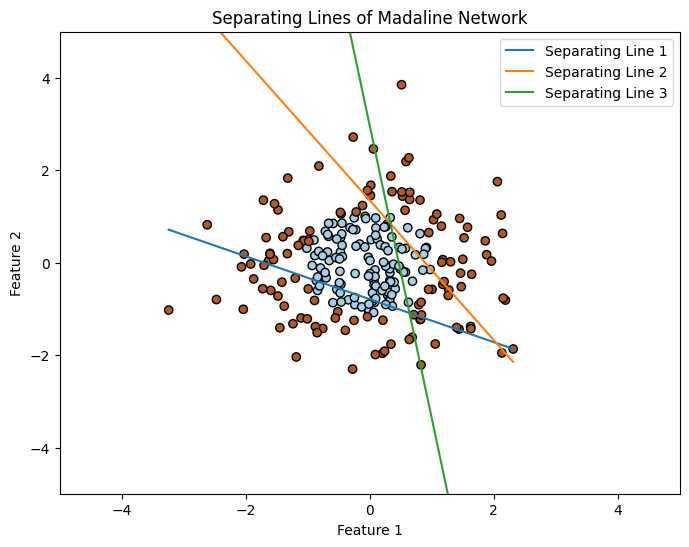

In [48]:
mad3_7  = Madaline(1e-3, 3000, 3)
hist3_7 = mad3_7.fit(X_train, y_train, 1e-4)
mad3_7.plot_separating_lines(X_train, y_train)

Accuracy on test set: 0.5833333333333334


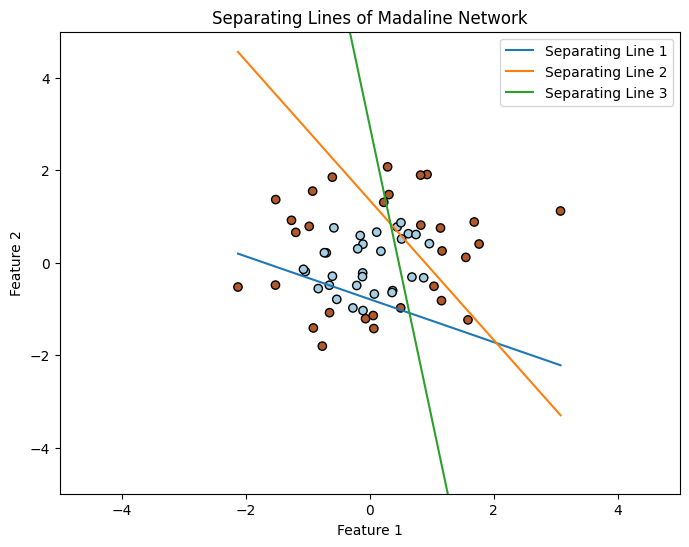

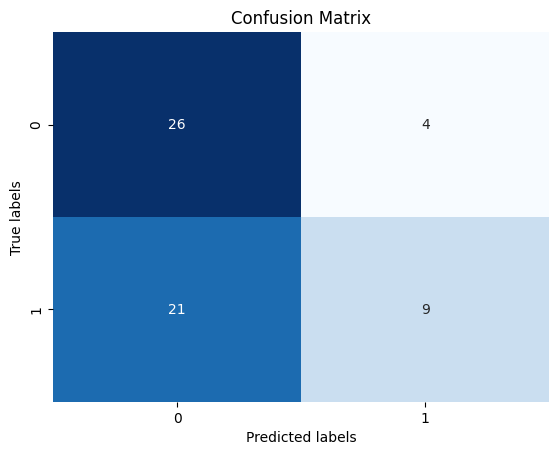

In [49]:
mad3_7.evaluate(X_test, y_test)

With 3000 epochs the accuracy decreases to 58%. But as we are looking for more accuracies, we try larger numbers and then we will make out conclusion.

**learning rate: 0.001, epochs: 5000**

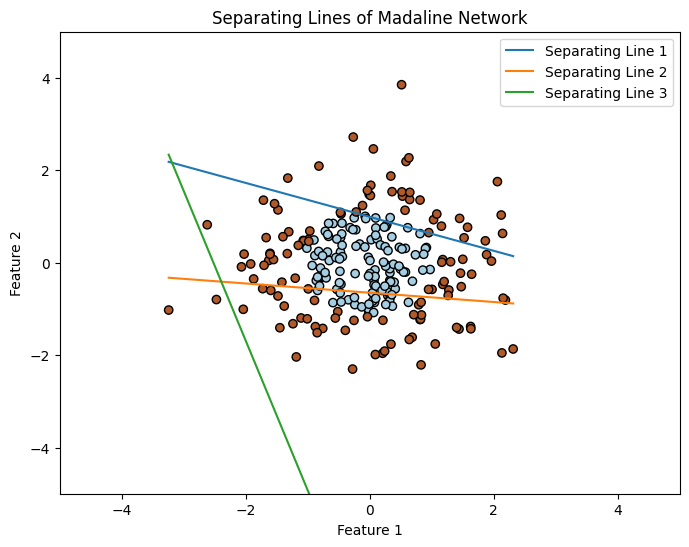

In [50]:
mad3_8  = Madaline(1e-3, 5000, 3)
hist3_8 = mad3_8.fit(X_train, y_train, 1e-4)
mad3_8.plot_separating_lines(X_train, y_train)

Accuracy on test set: 0.7833333333333333


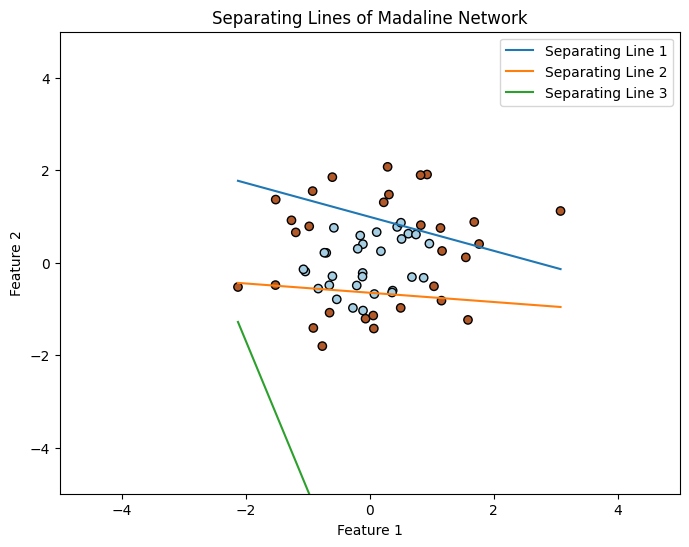

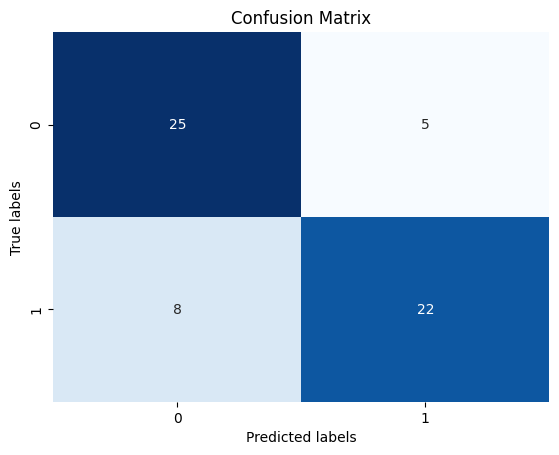

In [51]:
mad3_8.evaluate(X_test, y_test)

By increasnig number of epochs to 5000 accuracy increases to 78%. Thus, we can say that if we increase number of epochs, the accuracy does not always increase too, sometimes it goes up and somtimes down. But the best accuracy we obtained till know is 78% with lr = 0.001 and epochs = 5000.

<hr>

#### Madaline with 5 neurons in hidden layer

**learning rate: 0.001, epochs: 200**

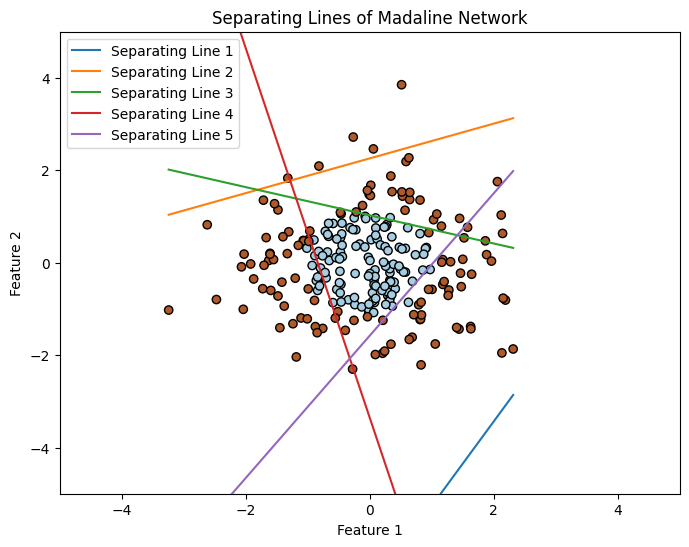

In [23]:
mad5_1  = Madaline(1e-3, 200, 5)
hist5_1 = mad5_1.fit(X_train, y_train, 1e-4)
mad5_1.plot_separating_lines(X_train, y_train)


Accuracy on test set: 0.85


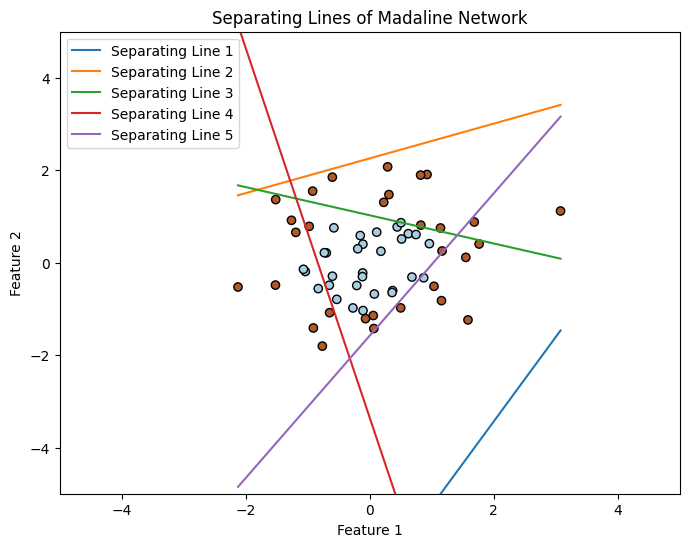

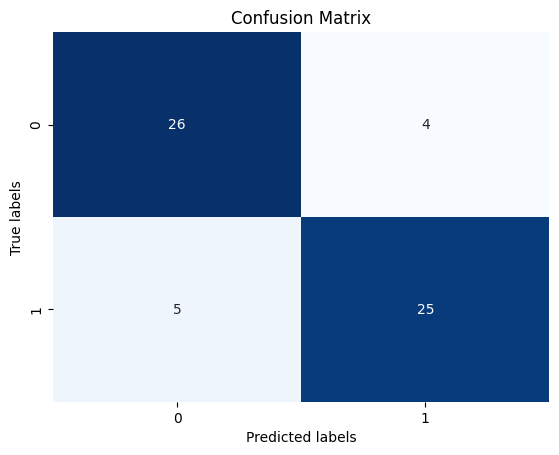

In [24]:
mad5_1.evaluate(X_test, y_test)

As we can see in the above pictures, the accuracy on test set is 85%. Know, we will change there parameters and see what happens!

Decrease number of epochs:

**learning rate: 0.001, epochs: 100**

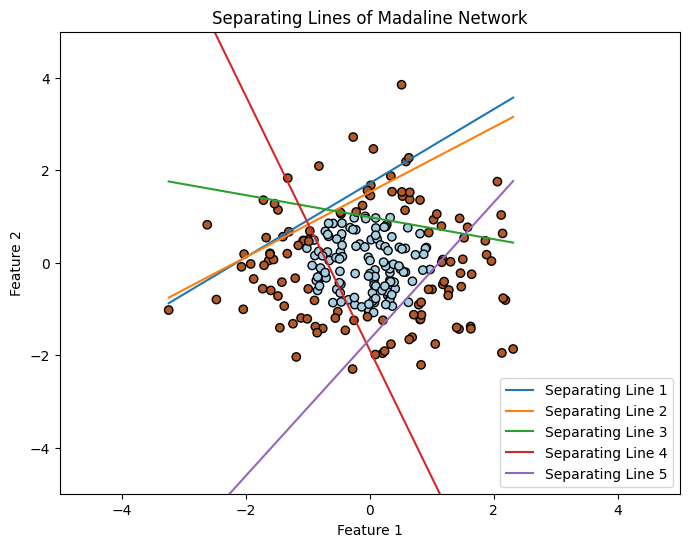

In [25]:
mad5_2  = Madaline(1e-3, 100, 5)
hist5_2 = mad5_2.fit(X_train, y_train, 1e-4)
mad5_2.plot_separating_lines(X_train, y_train)

Accuracy on test set: 0.75


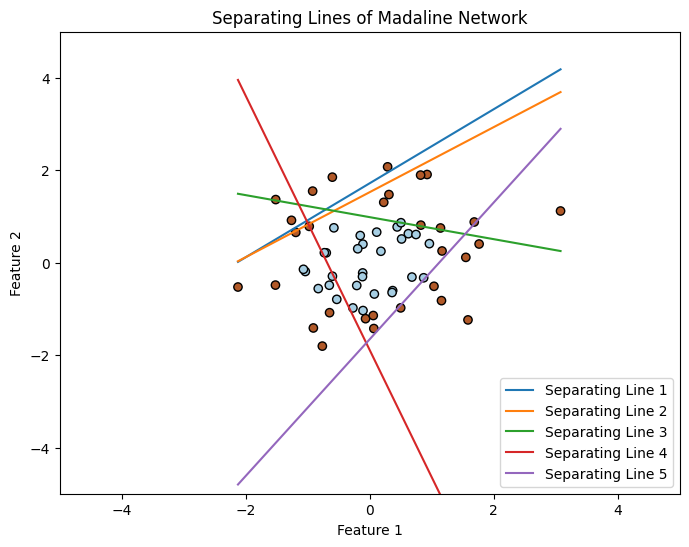

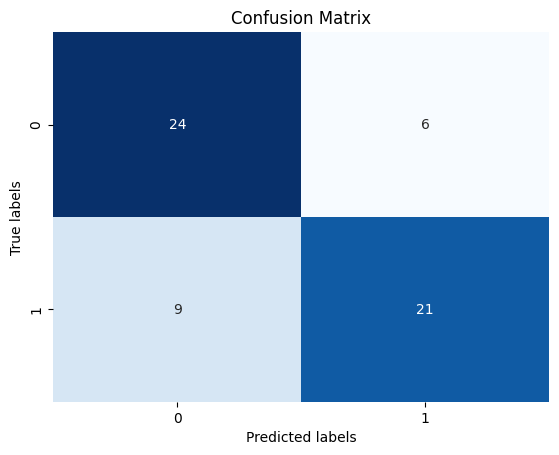

In [26]:
mad5_2.evaluate(X_test, y_test)

Decreasing number of epochs causes 75% accuracy which is less than before. So, let's try larger values.

**learning rate: 0.001, epochs: 300**

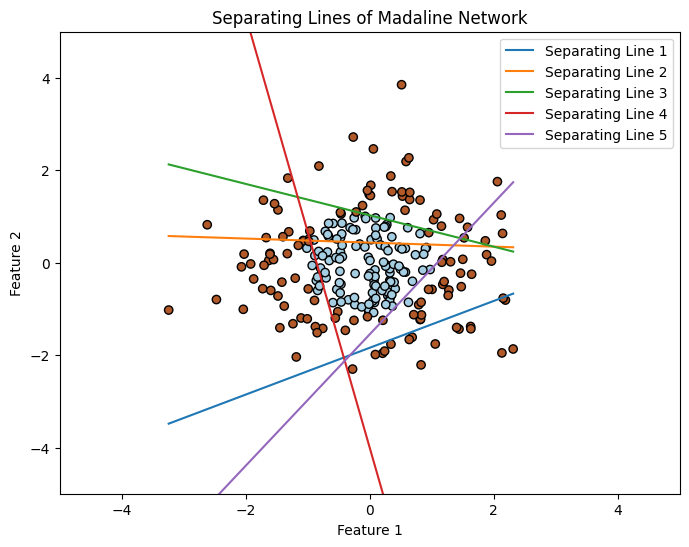

In [27]:
mad5_3  = Madaline(1e-3, 300, 5)
hist5_3 = mad5_3.fit(X_train, y_train, 1e-4)
mad5_3.plot_separating_lines(X_train, y_train)


Accuracy on test set: 0.6


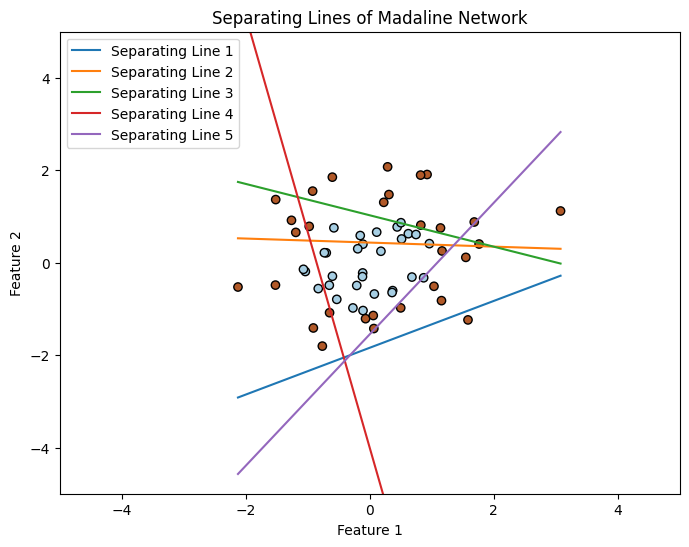

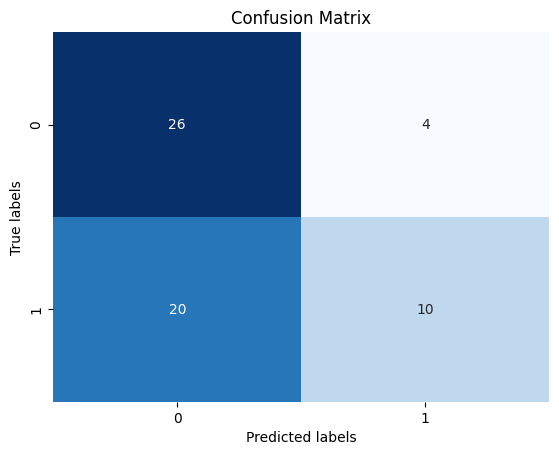

In [28]:
mad5_3.evaluate(X_test, y_test)

Increasing number of epochs by 100 epochs causes 60% accuracy which is again less than 85% we reached. Let's try dofferent values for learning rate.

**learning rate: 0.01, epochs: 200**

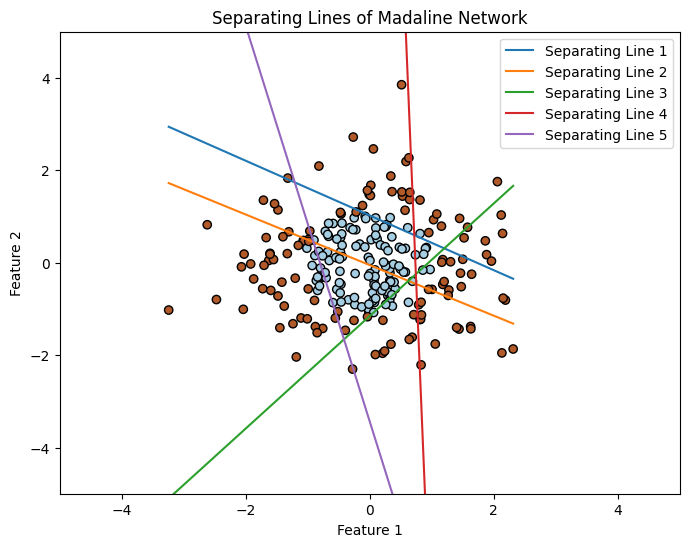

In [29]:
mad5_4  = Madaline(1e-2, 200, 5)
hist5_4 = mad5_4.fit(X_train, y_train, 1e-4)
mad5_4.plot_separating_lines(X_train, y_train)

Accuracy on test set: 0.5833333333333334


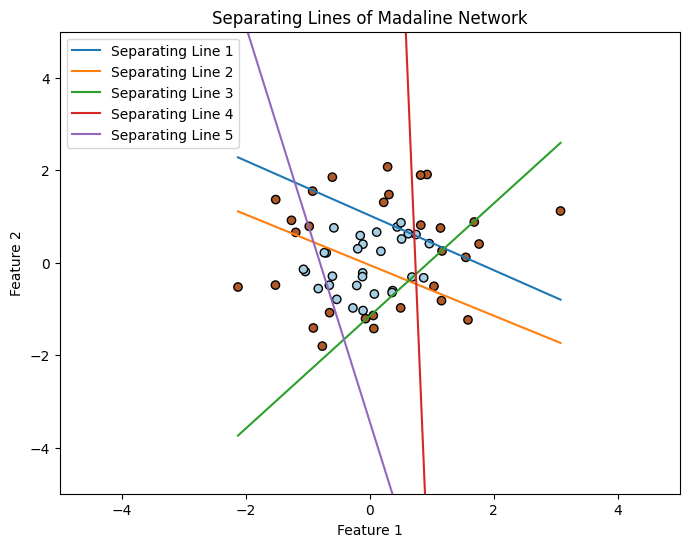

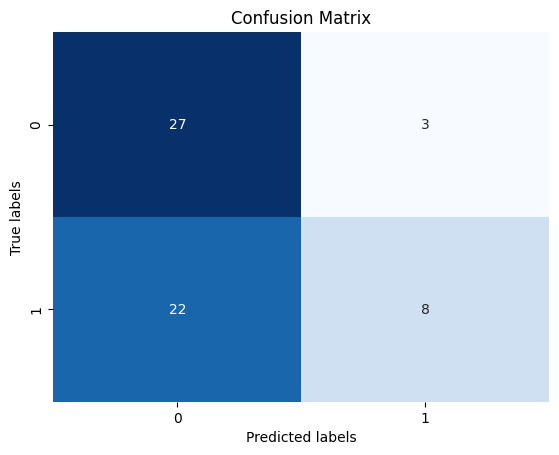

In [30]:
mad5_4.evaluate(X_test, y_test)

INcreasing learning rate also causes decrement in accuracy.(58%) Let's decrease it.

**learning rate: 0.0001, epochs: 200**

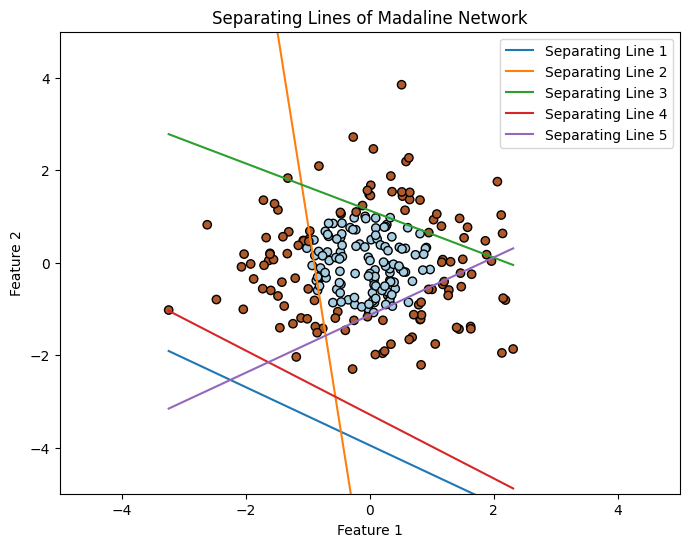

In [31]:
mad5_5  = Madaline(1e-4, 200, 5)
hist5_5 = mad5_5.fit(X_train, y_train, 1e-4)
mad5_5.plot_separating_lines(X_train, y_train)

Accuracy on test set: 0.8833333333333333


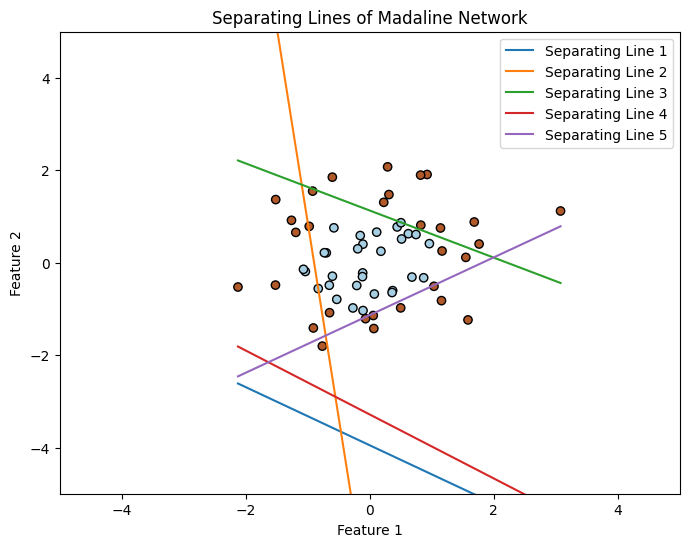

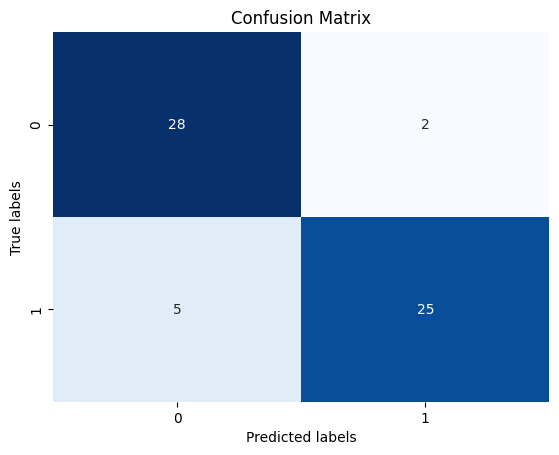

In [32]:
mad5_5.evaluate(X_test, y_test)

Decreasing learning rate caused 88% accuracy which is more than anithing else we reached before. Thus, by setting learning rate and number of epochs to 0.0001 and 200 respectively with 5 Adalines, we can get the best results.

<hr>

#### Madaline with 8 neurons in hidden layer

**learning rate: 0.001, epochs: 200**

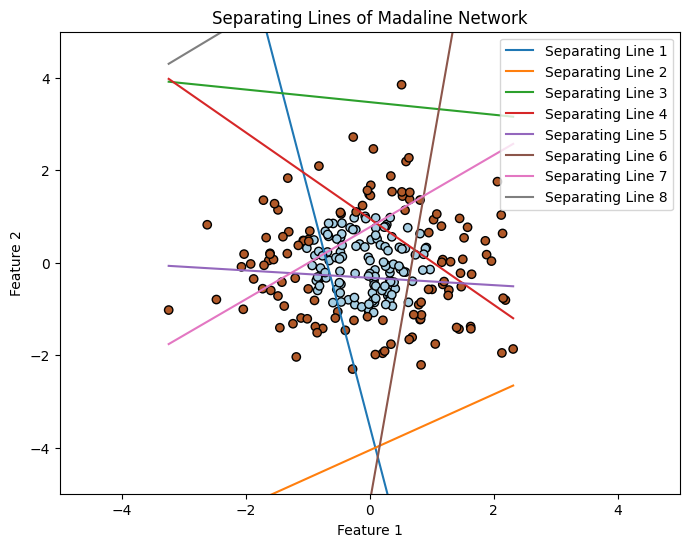

In [33]:
mad8_1  = Madaline(1e-3, 200, 8)
hist8_1 = mad8_1.fit(X_train, y_train, 1e-4)
mad8_1.plot_separating_lines(X_train, y_train)

Accuracy on test set: 0.8666666666666667


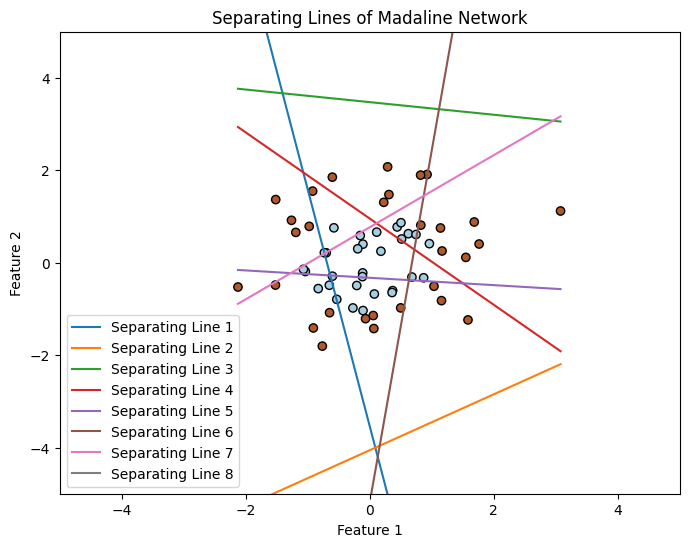

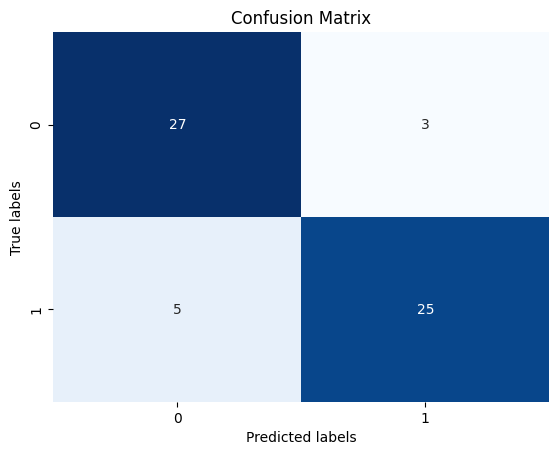

In [34]:
mad8_1.evaluate(X_test, y_test)

87% is the model's accuracy on the test set using this values for parameters. Now, let's consider different values for the parameters.

**learning rate: 0.001, epochs: 300**

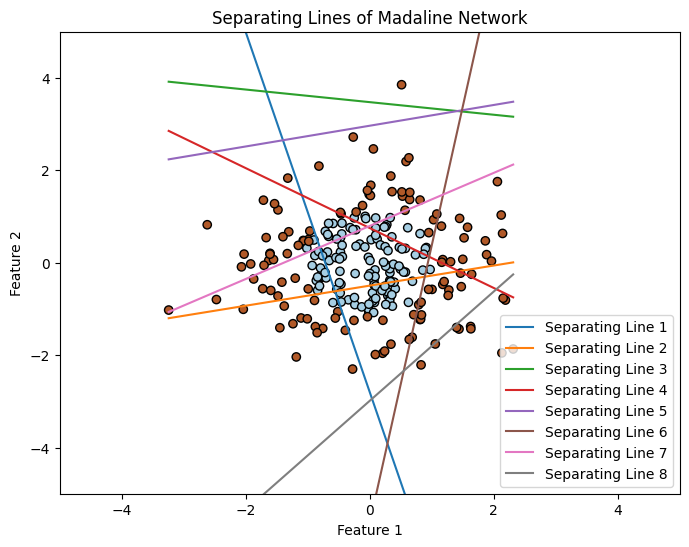

In [35]:
mad8_2  = Madaline(1e-3, 300, 8)
hist8_2 = mad8_2.fit(X_train, y_train, 1e-4)
mad8_2.plot_separating_lines(X_train, y_train)

Accuracy on test set: 0.85


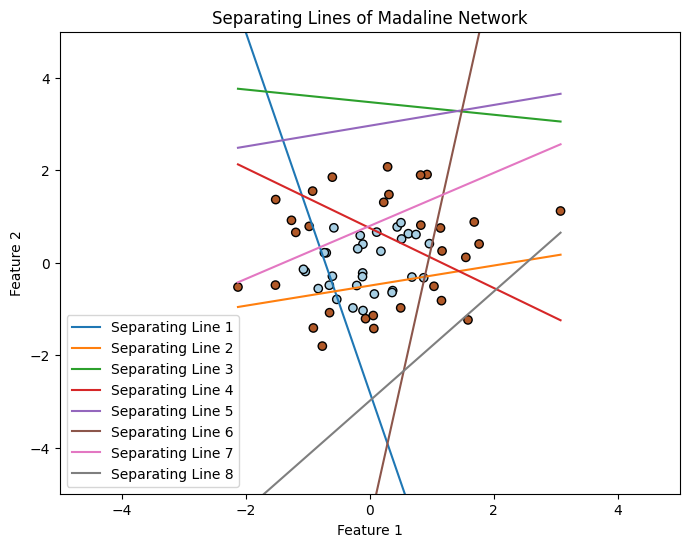

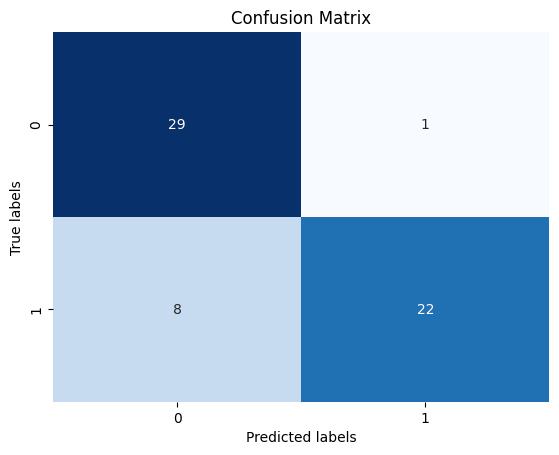

In [36]:
mad8_2.evaluate(X_test, y_test)

Increasing number of epochs to 300 caused derement in accuracy(85%). Thus we will test the model for smaller values.

**learning rate: 0.001, epochs: 100**

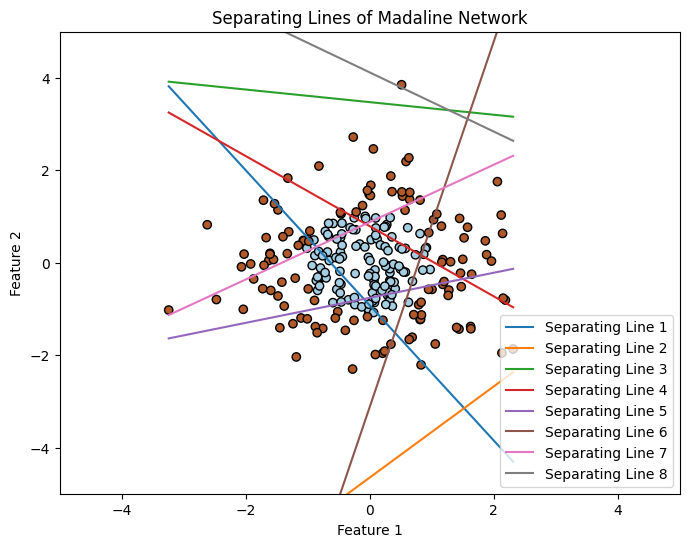

In [37]:
mad8_3  = Madaline(1e-3,100, 8)
hist8_3 = mad8_3.fit(X_train, y_train, 1e-4)
mad8_3.plot_separating_lines(X_train, y_train)

Accuracy on test set: 0.85


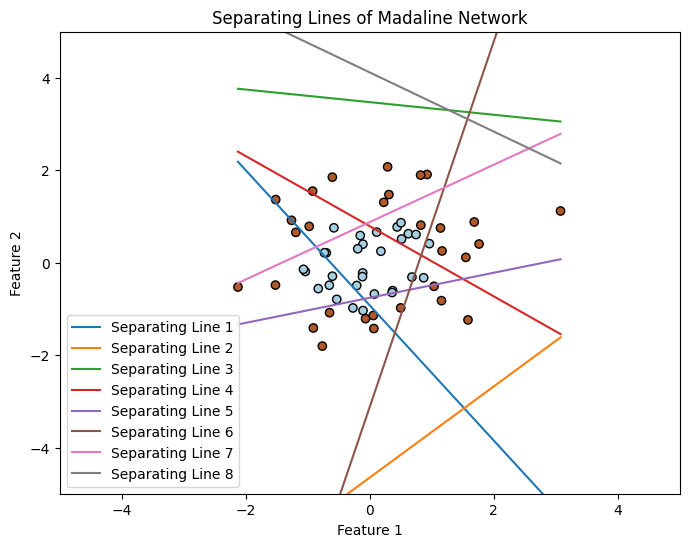

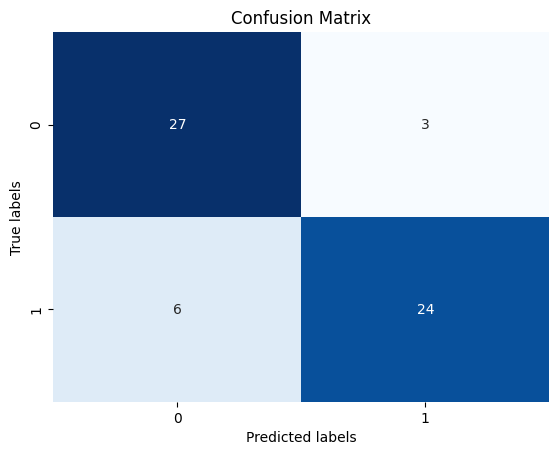

In [38]:
mad8_3.evaluate(X_test, y_test)

Decreasing number of epochs to 100 caused derement in accuracy too(85%). Thus we will test the model for different lr values and epochs = 200.

**learning rate: 0.01, epochs: 200**

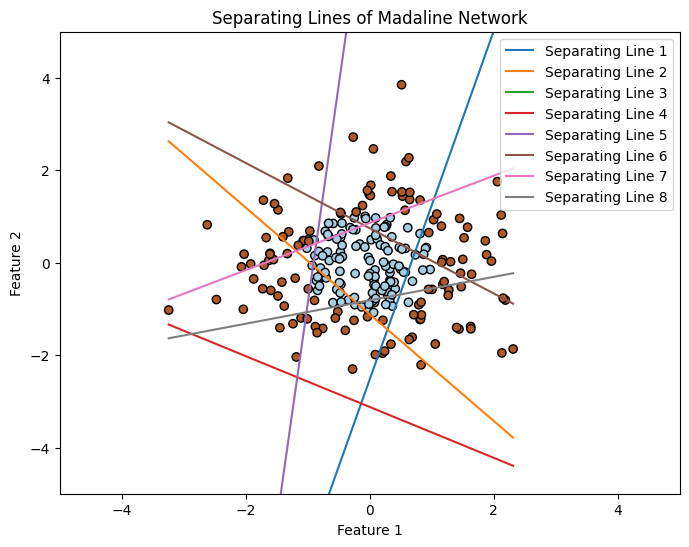

In [39]:
mad8_4  = Madaline(1e-2, 200, 8)
hist8_4 = mad8_4.fit(X_train, y_train, 1e-4)
mad8_4.plot_separating_lines(X_train, y_train)

Accuracy on test set: 0.8666666666666667


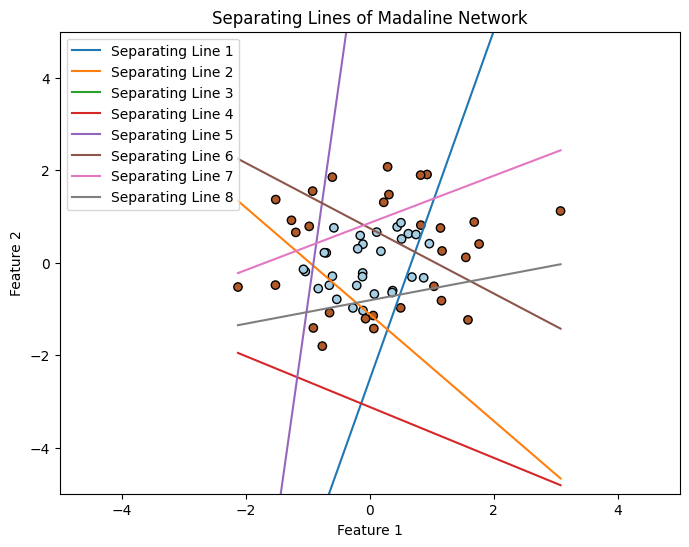

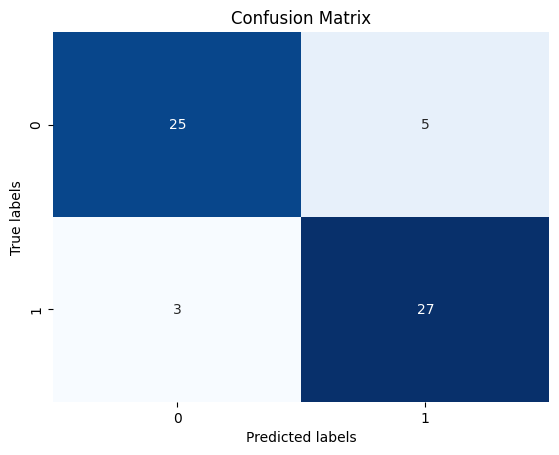

In [40]:
mad8_4.evaluate(X_test, y_test)

Increasing lr to 0.01 causes 87% accuracy. Let's consider smaller lr.

**learning rate: 0.0001, epochs: 200**

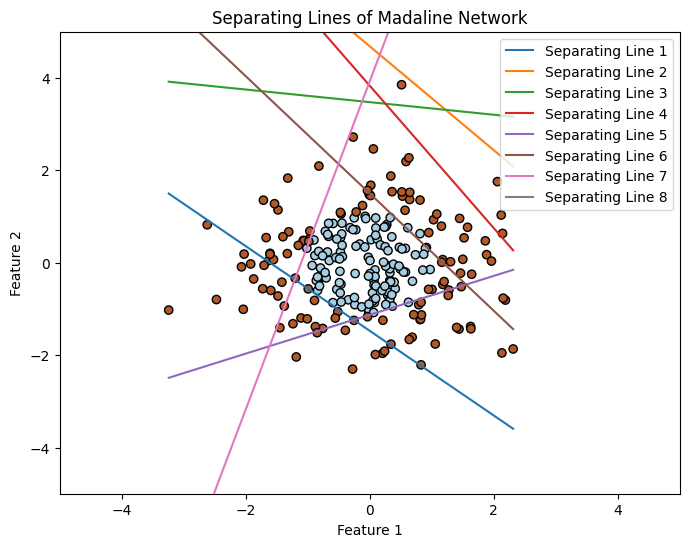

In [41]:
mad8_5  = Madaline(1e-4, 200, 8)
hist8_5 = mad8_5.fit(X_train, y_train, 1e-4)
mad8_5.plot_separating_lines(X_train, y_train)

Accuracy on test set: 0.9166666666666666


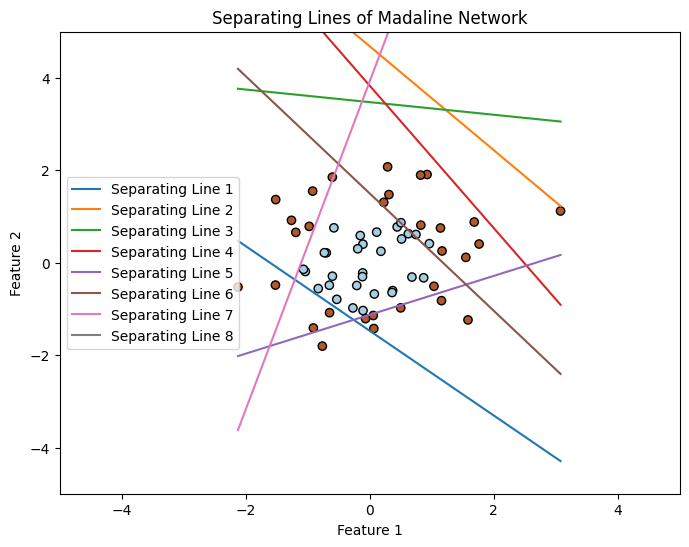

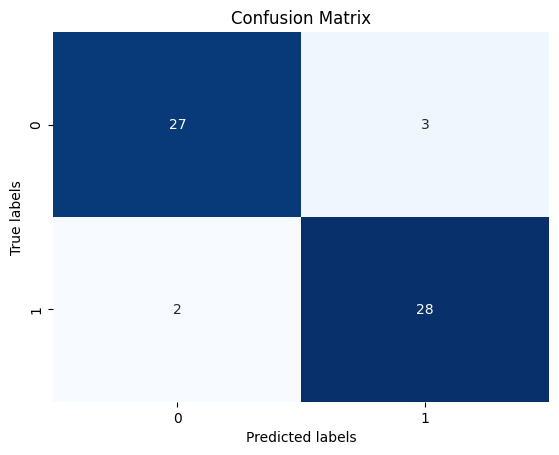

In [42]:
mad8_5.evaluate(X_test, y_test)

Decreasing lr causes 92% accuracy which means that decrement in learning rate
in 200 epochs results in better accuracy.

Overally, we can conclude that by increasibg number of Adalines in hidden layer, the accuracy increases too.